In [3]:
import requests
import zipfile
import io
import os
import pandas as pd
import numpy as np
from pathlib import Path
import tensorflow as tf
from sklearn.feature_extraction.text import TfidfVectorizer
import torch
import torchvision.transforms as transforms
from torchvision.models import resnet50
from PIL import Image
import matplotlib.pyplot as plt

### Шаг 1. Загрузите данные и проведите исследовательский анализ данных

Train Dataset:
                       image                     query_id  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2   
1  1262583859_653f1469a9.jpg  2549968784_39bfbe44f9.jpg#2   
2  2447284966_d6bbdb4b6e.jpg  2549968784_39bfbe44f9.jpg#2   
3  2549968784_39bfbe44f9.jpg  2549968784_39bfbe44f9.jpg#2   
4  2621415349_ef1a7e73be.jpg  2549968784_39bfbe44f9.jpg#2   

                                          query_text  
0  A young child is wearing blue goggles and sitt...  
1  A young child is wearing blue goggles and sitt...  
2  A young child is wearing blue goggles and sitt...  
3  A young child is wearing blue goggles and sitt...  
4  A young child is wearing blue goggles and sitt...  

Crowd Annotations:
                       image                     query_id  share_pos  \
0  1056338697_4f7d7ce270.jpg  1056338697_4f7d7ce270.jpg#2        1.0   
1  1056338697_4f7d7ce270.jpg   114051287_dd85625a04.jpg#2        0.0   
2  1056338697_4f7d7ce270.jpg  1427391496_ea512cbe7f.

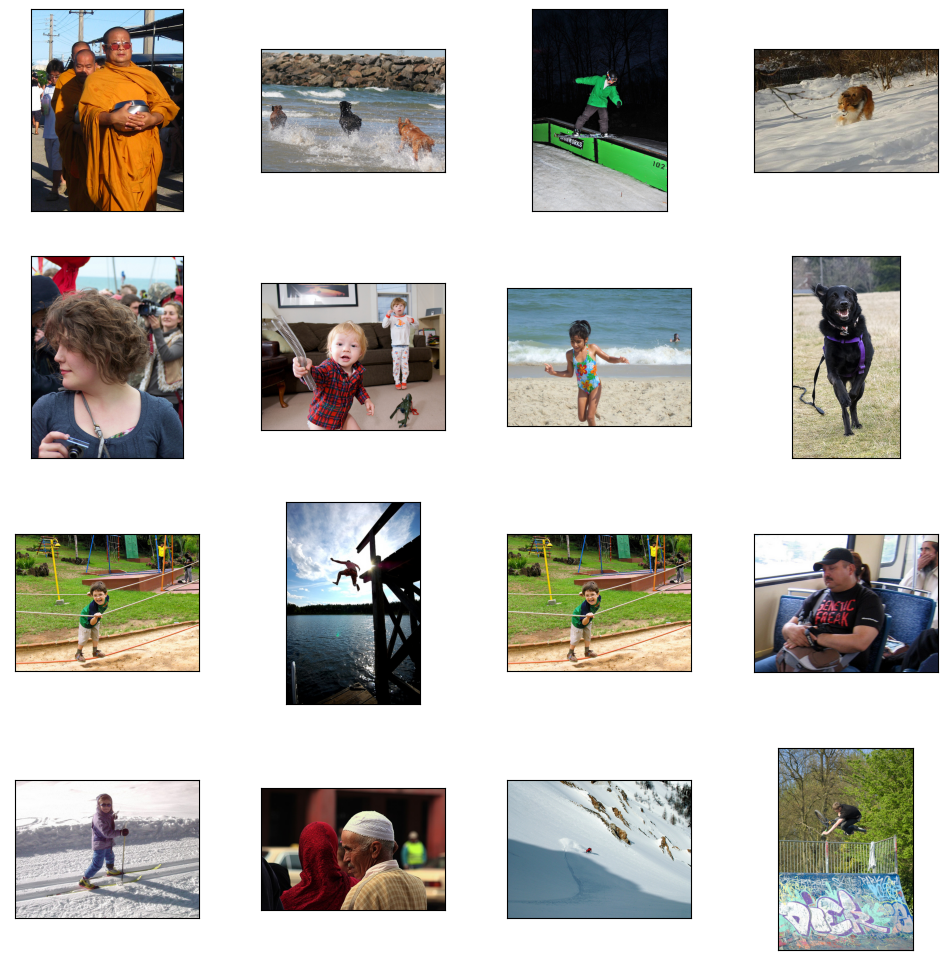

In [4]:
def read_df(path: str) -> tuple:
    '''Читаем датафреймы из указанной директории'''
    
    # Проверка наличия файлов перед чтением
    path = Path(path)
    train_path = path / 'train_dataset.csv'
    crowd_path = path / 'CrowdAnnotations.tsv'
    expert_path = path / 'ExpertAnnotations.tsv'
    queries_path = path / 'test_queries.csv'
    images_path = path / 'test_images.csv'
    
    if not train_path.exists():
        raise FileNotFoundError(f"Файл {train_path} не найден.")
    if not crowd_path.exists():
        raise FileNotFoundError(f"Файл {crowd_path} не найден.")
    if not expert_path.exists():
        raise FileNotFoundError(f"Файл {expert_path} не найден.")
    if not queries_path.exists():
        raise FileNotFoundError(f"Файл {queries_path} не найден.")
    if not images_path.exists():
        raise FileNotFoundError(f"Файл {images_path} не найден.")
    
    # Чтение данных
    df_train = pd.read_csv(train_path)
    df_crowd = pd.read_csv(crowd_path, sep='\t', names=['image', 'query_id', 'share_pos', 'count_pos', 'count_neg'])
    df_expert = pd.read_csv(expert_path, sep='\t', names=['image', 'query_id', 'first', 'second', 'third'])
    df_queries = pd.read_csv(queries_path, index_col=[0], sep='|')
    df_images = pd.read_csv(images_path, sep='|')
    
    return df_train, df_crowd, df_expert, df_queries, df_images

def display_images(path: str, df_train: pd.DataFrame, df_queries: pd.DataFrame):
    '''Отображение изображений из тренировочного и тестового наборов данных'''
    
    samples_train = list(df_train['image'].sample(8))
    samples_test = list(df_queries['image'].sample(8))
    
    fig, axes = plt.subplots(4, 4, figsize=(10, 10))
    fig.tight_layout()
    
    for i in range(8):
        train_image_path = Path(path) / 'train_images' / samples_train[i]
        test_image_path = Path(path) / 'test_images' / samples_test[i]
        
        # Отображение тренировочных изображений
        ax = axes[i // 4, i % 4]
        image = Image.open(train_image_path)
        ax.imshow(image)
        ax.set_xticks([])
        ax.set_yticks([])
        
        # Отображение тестовых изображений
        ax = axes[(i // 4) + 2, i % 4]
        image = Image.open(test_image_path)
        ax.imshow(image)
        ax.set_xticks([])
        ax.set_yticks([])

# Пример использования функции
path_to_data = 'C:\\datasets\\image_search\\to_upload'
df_train, df_crowd, df_expert, df_queries, df_images = read_df(path_to_data)

# Вывод первых нескольких строк каждого DataFrame для проверки
print("Train Dataset:")
print(df_train.head())
print("\nCrowd Annotations:")
print(df_crowd.head())
print("\nExpert Annotations:")
print(df_expert.head())
print("\nTest Queries:")
print(df_queries.head())
print("\nTest Images:")
print(df_images.head())

# Отображение изображений
display_images(path_to_data, df_train, df_queries)
plt.show()

In [5]:
display(df_train.head(), df_crowd.head(), df_expert.head(), df_queries.head(), df_images.head())

,image,query_id,query_text
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
1,1262583859_653f1469a9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
2,2447284966_d6bbdb4b6e.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
3,2549968784_39bfbe44f9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
4,2621415349_ef1a7e73be.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...


,image,query_id,share_pos,count_pos,count_neg
0,1056338697_4f7d7ce270.jpg,1056338697_4f7d7ce270.jpg#2,1.0,3,0
1,1056338697_4f7d7ce270.jpg,114051287_dd85625a04.jpg#2,0.0,0,3
2,1056338697_4f7d7ce270.jpg,1427391496_ea512cbe7f.jpg#2,0.0,0,3
3,1056338697_4f7d7ce270.jpg,2073964624_52da3a0fc4.jpg#2,0.0,0,3
4,1056338697_4f7d7ce270.jpg,2083434441_a93bc6306b.jpg#2,0.0,0,3


,image,query_id,first,second,third
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,1,1,1
1,1056338697_4f7d7ce270.jpg,2718495608_d8533e3ac5.jpg#2,1,1,2
2,1056338697_4f7d7ce270.jpg,3181701312_70a379ab6e.jpg#2,1,1,2
3,1056338697_4f7d7ce270.jpg,3207358897_bfa61fa3c6.jpg#2,1,2,2
4,1056338697_4f7d7ce270.jpg,3286822339_5535af6b93.jpg#2,1,1,2


,query_id,query_text,image
0,1177994172_10d143cb8d.jpg#0,"Two blonde boys , one in a camouflage shirt an...",1177994172_10d143cb8d.jpg
1,1177994172_10d143cb8d.jpg#1,Two boys are squirting water guns at each other .,1177994172_10d143cb8d.jpg
2,1177994172_10d143cb8d.jpg#2,Two boys spraying each other with water,1177994172_10d143cb8d.jpg
3,1177994172_10d143cb8d.jpg#3,Two children wearing jeans squirt water at eac...,1177994172_10d143cb8d.jpg
4,1177994172_10d143cb8d.jpg#4,Two young boys are squirting water at each oth...,1177994172_10d143cb8d.jpg


,image
0,3356748019_2251399314.jpg
1,2887171449_f54a2b9f39.jpg
2,3089107423_81a24eaf18.jpg
3,1429546659_44cb09cbe2.jpg
4,1177994172_10d143cb8d.jpg


In [6]:
# Функция для отображения общей информации о каждом DataFrame
def display_info(df_list, names):
    for df, name in zip(df_list, names):
        print(f"\n{name} Dataset Info:")
        print(df.info())
        print("\nMissing values:")
        print(df.isnull().sum())
        print("\nHead of the dataset:")
        print(df.head())
        print("\n")

# Список DataFrame'ов и их имена
df_list = [df_train, df_crowd, df_expert, df_queries, df_images]
names = ['Train', 'Crowd Annotations', 'Expert Annotations', 'Test Queries', 'Test Images']

# Отображение информации
display_info(df_list, names)


Train Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image       5822 non-null   object
 1   query_id    5822 non-null   object
 2   query_text  5822 non-null   object
dtypes: object(3)
memory usage: 136.6+ KB
None

Missing values:
image         0
query_id      0
query_text    0
dtype: int64

Head of the dataset:
                       image                     query_id  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2   
1  1262583859_653f1469a9.jpg  2549968784_39bfbe44f9.jpg#2   
2  2447284966_d6bbdb4b6e.jpg  2549968784_39bfbe44f9.jpg#2   
3  2549968784_39bfbe44f9.jpg  2549968784_39bfbe44f9.jpg#2   
4  2621415349_ef1a7e73be.jpg  2549968784_39bfbe44f9.jpg#2   

                                          query_text  
0  A young child is wearing blue goggles and sitt...  
1  A young child is wearing blue goggles and sitt

In [7]:
# Функция для отображения описательных статистик каждого DataFrame
def display_statistics(df_list, names):
    for df, name in zip(df_list, names):
        print(f"\n{name} Dataset Statistics:")
        print(df.describe())
        print("\n")

# Отображение описательных статистик
display_statistics(df_list, names)


Train Dataset Statistics:
                            image                     query_id  \
count                        5822                         5822   
unique                       1000                          977   
top     3364151356_eecd07a23e.jpg  2600867924_cd502fc911.jpg#2   
freq                           10                           34   

                                               query_text  
count                                                5822  
unique                                                977  
top     Two dogs , one brown and white and one black a...  
freq                                                   34  



Crowd Annotations Dataset Statistics:
          share_pos     count_pos     count_neg
count  47830.000000  47830.000000  47830.000000
mean       0.068786      0.208488      2.820155
std        0.207532      0.628898      0.656676
min        0.000000      0.000000      0.000000
25%        0.000000      0.000000      3.000000
50%        0.

In [8]:
# Проверка наличия данных в каждом DataFrame
df_list = [df_train, df_crowd, df_expert, df_queries, df_images]
names = ['Train', 'Crowd Annotations', 'Expert Annotations', 'Test Queries', 'Test Images']

for df, name in zip(df_list, names):
    print(f"{name} dataset shape: {df.shape}")

Train dataset shape: (5822, 3)
Crowd Annotations dataset shape: (47830, 5)
Expert Annotations dataset shape: (5822, 5)
Test Queries dataset shape: (500, 3)
Test Images dataset shape: (100, 1)


In [9]:
# Проверка на наличие пустых строк и колонок
for df, name in zip(df_list, names):
    print(f"{name} dataset:")
    print(df.isnull().sum())
    print()

Train dataset:
image         0
query_id      0
query_text    0
dtype: int64

Crowd Annotations dataset:
image        0
query_id     0
share_pos    0
count_pos    0
count_neg    0
dtype: int64

Expert Annotations dataset:
image       0
query_id    0
first       0
second      0
third       0
dtype: int64

Test Queries dataset:
query_id      0
query_text    0
image         0
dtype: int64

Test Images dataset:
image    0
dtype: int64



In [10]:
# Проверка типов данных
for df, name in zip(df_list, names):
    print(f"{name} dataset types:")
    print(df.dtypes)
    print()

Train dataset types:
image         object
query_id      object
query_text    object
dtype: object

Crowd Annotations dataset types:
image         object
query_id      object
share_pos    float64
count_pos      int64
count_neg      int64
dtype: object

Expert Annotations dataset types:
image       object
query_id    object
first        int64
second       int64
third        int64
dtype: object

Test Queries dataset types:
query_id      object
query_text    object
image         object
dtype: object

Test Images dataset types:
image    object
dtype: object



In [11]:
# Проверка на дублирующиеся строки
for df, name in zip(df_list, names):
    duplicates = df.duplicated().sum()
    print(f"{name} dataset has {duplicates} duplicate rows.")
    print()

Train dataset has 0 duplicate rows.

Crowd Annotations dataset has 0 duplicate rows.

Expert Annotations dataset has 0 duplicate rows.

Test Queries dataset has 0 duplicate rows.

Test Images dataset has 0 duplicate rows.



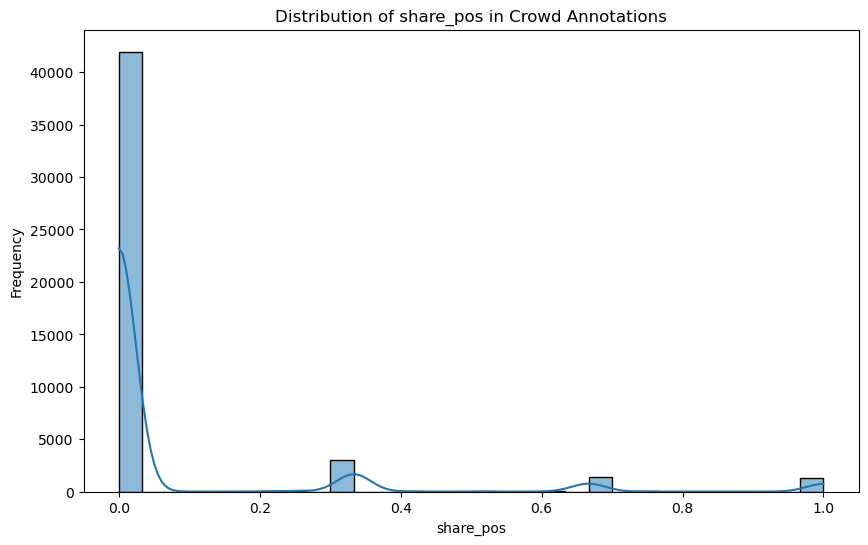

df_train does not contain numerical data for correlation matrix.


In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# Проверка наличия столбца 'share_pos' в df_crowd
if 'share_pos' in df_crowd.columns:
    # Пример визуализации распределения значений в Crowd Annotations
    plt.figure(figsize=(10, 6))
    sns.histplot(df_crowd['share_pos'], bins=30, kde=True)
    plt.title('Distribution of share_pos in Crowd Annotations')
    plt.xlabel('share_pos')
    plt.ylabel('Frequency')
    plt.show()
else:
    print("Column 'share_pos' does not exist in df_crowd")

# Проверка наличия числовых данных в df_train
if not df_train.select_dtypes(include=[np.number]).empty:
    # Пример визуализации корреляционной матрицы в Train Dataset
    plt.figure(figsize=(12, 10))
    sns.heatmap(df_train.corr(), annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5)
    plt.title('Correlation Matrix of Train Dataset')
    plt.show()
else:
    print("df_train does not contain numerical data for correlation matrix.")

In [13]:
try:
    if 'image' in df_train.columns:
        unique_train_images = len(df_train['image'].unique())
        print('Количество уникальных фото на трейне:', unique_train_images)
    else:
        print("Столбец 'image' отсутствует в df_train")

    if 'image' in df_queries.columns:
        unique_test_images = len(df_queries['image'].unique())
        print('Количество уникальных фото на тесте:', unique_test_images)
    else:
        print("Столбец 'image' отсутствует в df_queries")
except Exception as e:
    print(f"Произошла ошибка: {e}")

Количество уникальных фото на трейне: 1000
Количество уникальных фото на тесте: 100


In [14]:
try:
    # Проверка наличия необходимых столбцов
    if not df_expert.empty:
        unique_expert_combinations = df_expert.drop_duplicates().shape[0]
        print('Количество уникальных сочетаний фото-текст оцененных экспертами:', unique_expert_combinations)
    else:
        print("DataFrame df_expert пустой или не содержит данных")

    if not df_crowd.empty:
        unique_crowd_combinations = df_crowd.drop_duplicates().shape[0]
        print('Количество уникальных сочетаний фото-текст оцененных людьми:', unique_crowd_combinations)
    else:
        print("DataFrame df_crowd пустой или не содержит данных")
except Exception as e:
    print(f"Произошла ошибка: {e}")

Количество уникальных сочетаний фото-текст оцененных экспертами: 5822
Количество уникальных сочетаний фото-текст оцененных людьми: 47830


In [15]:
df_expert.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   image     5822 non-null   object
 1   query_id  5822 non-null   object
 2   first     5822 non-null   int64 
 3   second    5822 non-null   int64 
 4   third     5822 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 227.5+ KB


### Шаг 2. Подготовьте данные к обучению модели

1. Создайте список слов которые, по вашему мнению, могут попадать под юридические ограничения.

2. Исключите из обучающего датасета пары, которые, исходя из подготовленного вами списка слов, могут попадать под юридические ограничения.

3. Сделайте векторизацию текстового описания одним из следующих методов:

- TF-IDF;

- BERT;

- word2vec.

4. Сделайте векторизацию изображений с использованием модели ResNet50 из библиотеки Keras или PyTorch.

5. Дайте описание получившихся пар векторов с точки зрения их размерностей.

In [16]:
# Проверка наличия столбца 'query_text'
print(df_train.columns)

Index(['image', 'query_id', 'query_text'], dtype='object')


In [17]:
column_name = 'query_text'

restricted_words = [
    'weapon', 'drugs', 'violence', 'terrorism', 
    'pornography', 'extremism', 'murder', 'suicide'
]

In [18]:
def filter_restricted_pairs(df_train: pd.DataFrame, restricted_words: list, column_name: str) -> pd.DataFrame:
    '''Exclude pairs with restricted words from the training dataset'''
    pattern = '|'.join(restricted_words)
    filtered_df = df_train[~df_train[column_name].str.contains(pattern, case=False, na=False)]
    return filtered_df

In [19]:
df_train_filtered = filter_restricted_pairs(df_train, restricted_words, column_name)

In [20]:
vectorizer = TfidfVectorizer(max_features=5000)  # Limit the number of features
text_vectors = vectorizer.fit_transform(df_train_filtered[column_name])

In [21]:
# Загрузка предобученной модели ResNet50 и удаление последнего слоя
model = resnet50(pretrained=True)
model = torch.nn.Sequential(*list(model.children())[:-1])  # Удаляем последний слой

C:\Users\Пользователь\AppData\Roaming\Python\Python39\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Пользователь\AppData\Roaming\Python\Python39\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [22]:
# Преобразования для изображений
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [23]:
def preprocess_image(img_path):
    '''Предобработка изображения для ввода в модель ResNet50'''
    img = Image.open(img_path).convert('RGB')
    img_tensor = preprocess(img)
    img_tensor = img_tensor.unsqueeze(0)  # Добавляем размерность для батча
    return img_tensor

In [24]:
def get_image_vector(model, img_path):
    '''Получить вектор изображения'''
    img_tensor = preprocess_image(img_path)
    with torch.no_grad():
        img_vector = model(img_tensor)
    return img_vector.flatten().numpy()

In [25]:
# Пример получения векторов для изображений из обучающего набора данных
image_vectors = np.array([get_image_vector(model, Path(path_to_data) / 'train_images' / img) for img in df_train_filtered['image']])

In [26]:
print(df_train_filtered.columns)

Index(['image', 'query_id', 'query_text'], dtype='object')


In [28]:
from sklearn.model_selection import train_test_split
# Проверка размеров массивов
assert text_vectors.shape[0] == image_vectors.shape[0], "Количество строк в text_vectors и image_vectors должно совпадать"

# Конкатенация текстовых и изображенческих векторов
combined_vectors = np.hstack((text_vectors.toarray(), image_vectors))

# Убедимся, что количество строк в df_expert совпадает с количеством строк в combined_vectors
assert df_expert.shape[0] == combined_vectors.shape[0], "Количество строк в df_expert и combined_vectors должно совпадать"

# Создание столбца 'expert_score' путем усреднения значений столбцов 'first', 'second' и 'third'
df_expert['expert_score'] = df_expert[['first', 'second', 'third']].mean(axis=1)

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(combined_vectors, df_expert['expert_score'], test_size=0.2, random_state=42)

# Вывод размеров выборок для проверки
print(f"Размеры обучающей выборки: X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"Размеры тестовой выборки: X_test: {X_test.shape}, y_test: {y_test.shape}")

Размеры обучающей выборки: X_train: (4657, 3558), y_train: (4657,)
Размеры тестовой выборки: X_test: (1165, 3558), y_test: (1165,)


### Шаг 3 Обучите модель

- Создайте модель, которая покажет близость двух векторов. Модель должна принимать на вход конкатенированный вектор, состоящий из векторов описания и изображений, и предсказывать итоговую оценку экспертов.

- Выберите метрику, по которой вы будете сравнивать точность различных моделей.

- Обучите несколько моделей и подберите их гиперпараметры. 

- В качестве моделей обязательно нужно рассмотреть:

1. Линейную регрессию;

2. Полносвязные нейронные сети.

In [45]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
from PIL import Image
import os


In [29]:
# Обучение модели линейной регрессии
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

# Предсказание на тестовой выборке
y_pred_linear = linear_model.predict(X_test)

# Оценка модели
mae_linear = mean_absolute_error(y_test, y_pred_linear)
print(f"MAE для линейной регрессии: {mae_linear}")

MAE для линейной регрессии: 98981635940.70413


In [30]:
# Определение модели нейронной сети
def create_nn_model(input_dim):
    model = Sequential()
    model.add(Dense(64, input_dim=input_dim, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1, activation='linear'))
    
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_absolute_error')
    return model

input_dim = X_train.shape[1]
nn_model = create_nn_model(input_dim)

# Обучение модели нейронной сети
nn_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=1)

# Предсказание на тестовой выборке
y_pred_nn = nn_model.predict(X_test)

# Оценка модели
mae_nn = mean_absolute_error(y_test, y_pred_nn)
print(f"MAE для полносвязной нейронной сети: {mae_nn}")


Epoch 1/50

117/117 [==============================] - 2s 6ms/step - loss: 0.6658 - val_loss: 0.5761
Epoch 2/50
117/117 [==============================] - 1s 5ms/step - loss: 0.6062 - val_loss: 0.5926
Epoch 3/50
117/117 [==============================] - 0s 4ms/step - loss: 0.6090 - val_loss: 0.5819
Epoch 4/50
117/117 [==============================] - 0s 4ms/step - loss: 0.6016 - val_loss: 0.5849
Epoch 5/50
117/117 [==============================] - 0s 4ms/step - loss: 0.6057 - val_loss: 0.5855
Epoch 6/50
117/117 [==============================] - 0s 4ms/step - loss: 0.6145 - val_loss: 0.5613
Epoch 7/50
117/117 [==============================] - 1s 5ms/step - loss: 0.6022 - val_loss: 0.5704
Epoch 8/50
117/117 [==============================] - 0s 4ms/step - loss: 0.5994 - val_loss: 0.5772
Epoch 9/50
117/117 [==============================] - 1s 4ms/step - loss: 0.6077 - val_loss: 0.5716
Epoch 10/50
117/117 [==============================] - 1s 5ms/step - loss: 0.6040 - val_loss: 0.62

In [32]:
# Преобразование данных в тензоры PyTorch
X_train, X_temp, y_train, y_temp = train_test_split(combined_vectors, df_expert['expert_score'], test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

X_train = torch.tensor(X_train, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
y_val = torch.tensor(y_val.values, dtype=torch.float32).view(-1, 1)
y_test = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

In [35]:
class RegressionNN(nn.Module):
    def __init__(self, input_dim):
        super(RegressionNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

input_dim = X_train.shape[1]
model = RegressionNN(input_dim)

In [36]:
criterion = nn.L1Loss()  # Mean Absolute Error
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [37]:
num_epochs = 50
batch_size = 32

# Создание DataLoader для батчей
train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

best_model_wts = None
best_val_mae = float('inf')

for epoch in range(num_epochs):
    model.train()
    for i, (inputs, targets) in enumerate(train_loader):
        # Обнуление градиентов
        optimizer.zero_grad()
        
        # Прямой проход
        outputs = model(inputs)
        
        # Вычисление функции потерь
        loss = criterion(outputs, targets)
        
        # Обратный проход и оптимизация
        loss.backward()
        optimizer.step()
    
    # Оценка на валидационной выборке
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val)
        val_loss = criterion(val_outputs, y_val).item()
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Val Loss: {val_loss:.4f}')
    
    # Сохранение лучшей модели
    if val_loss < best_val_mae:
        best_val_mae = val_loss
        best_model_wts = model.state_dict()

# Загрузка лучших весов модели
model.load_state_dict(best_model_wts)

Epoch [1/50], Loss: 0.2948, Val Loss: 0.6086
Epoch [2/50], Loss: 0.4964, Val Loss: 0.6099
Epoch [3/50], Loss: 0.5408, Val Loss: 0.6027
Epoch [4/50], Loss: 0.4121, Val Loss: 0.6036
Epoch [5/50], Loss: 0.4921, Val Loss: 0.6025
Epoch [6/50], Loss: 0.6444, Val Loss: 0.6384
Epoch [7/50], Loss: 0.3800, Val Loss: 0.6177
Epoch [8/50], Loss: 0.6804, Val Loss: 0.6027
Epoch [9/50], Loss: 0.5956, Val Loss: 0.6057
Epoch [10/50], Loss: 0.6071, Val Loss: 0.6151
Epoch [11/50], Loss: 0.8620, Val Loss: 0.6062
Epoch [12/50], Loss: 0.5080, Val Loss: 0.6273
Epoch [13/50], Loss: 0.8242, Val Loss: 0.6261
Epoch [14/50], Loss: 0.3951, Val Loss: 0.6199
Epoch [15/50], Loss: 0.8779, Val Loss: 0.6333
Epoch [16/50], Loss: 0.2300, Val Loss: 0.6263
Epoch [17/50], Loss: 0.2370, Val Loss: 0.6396
Epoch [18/50], Loss: 0.5345, Val Loss: 0.6156
Epoch [19/50], Loss: 0.5815, Val Loss: 0.6134
Epoch [20/50], Loss: 0.8272, Val Loss: 0.6123
Epoch [21/50], Loss: 0.7564, Val Loss: 0.6153
Epoch [22/50], Loss: 0.7166, Val Loss: 0.63

<All keys matched successfully>

In [39]:
model.eval()  # Переключение модели в режим оценки
with torch.no_grad():
    y_pred_nn = model(X_test)

# Преобразование предсказаний в numpy массив для оценки метрики MAE
y_pred_nn = y_pred_nn.numpy()

mae_nn = mean_absolute_error(y_test.numpy(), y_pred_nn)
print(f"MAE для полносвязной нейронной сети на тестовой выборке: {mae_nn}")

MAE для полносвязной нейронной сети на тестовой выборке: 0.5975633263587952


### Шаг 4. Тестирование модели и демонстрация ее работы

- Проведите тестирование лучшей модели на тестовых данных.

- Напишите функцию, которая принимает на вход текстовое описание, делает его векторизацию и возвращает картинку с максимальным значением метрики.

In [40]:
# Определение функции потерь и оптимизатора
criterion = nn.L1Loss()  # Mean Absolute Error
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Обучение модели с использованием валидационной выборки
num_epochs = 50
batch_size = 32

# Создание DataLoader для батчей
train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

best_model_wts = None
best_val_mae = float('inf')

for epoch in range(num_epochs):
    model.train()
    for i, (inputs, targets) in enumerate(train_loader):
        # Обнуление градиентов
        optimizer.zero_grad()
        
        # Прямой проход
        outputs = model(inputs)
        
        # Вычисление функции потерь
        loss = criterion(outputs, targets)
        
        # Обратный проход и оптимизация
        loss.backward()
        optimizer.step()
    
    # Оценка на валидационной выборке
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val)
        val_loss = criterion(val_outputs, y_val).item()
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Val Loss: {val_loss:.4f}')
    
    # Сохранение лучшей модели
    if val_loss < best_val_mae:
        best_val_mae = val_loss
        best_model_wts = model.state_dict()

# Загрузка лучших весов модели
model.load_state_dict(best_model_wts)

Epoch [1/50], Loss: 0.3925, Val Loss: 0.6154
Epoch [2/50], Loss: 0.7671, Val Loss: 0.6107
Epoch [3/50], Loss: 0.4659, Val Loss: 0.6116
Epoch [4/50], Loss: 0.2298, Val Loss: 0.6151
Epoch [5/50], Loss: 0.3256, Val Loss: 0.6363
Epoch [6/50], Loss: 0.4967, Val Loss: 0.6174
Epoch [7/50], Loss: 0.3193, Val Loss: 0.6386
Epoch [8/50], Loss: 0.3315, Val Loss: 0.6197
Epoch [9/50], Loss: 0.5327, Val Loss: 0.6291
Epoch [10/50], Loss: 0.7556, Val Loss: 0.6365
Epoch [11/50], Loss: 0.9172, Val Loss: 0.6019
Epoch [12/50], Loss: 0.1696, Val Loss: 0.6530
Epoch [13/50], Loss: 0.3598, Val Loss: 0.6110
Epoch [14/50], Loss: 0.4566, Val Loss: 0.6061
Epoch [15/50], Loss: 0.6463, Val Loss: 0.6099
Epoch [16/50], Loss: 0.8881, Val Loss: 0.6067
Epoch [17/50], Loss: 0.4395, Val Loss: 0.6128
Epoch [18/50], Loss: 0.4218, Val Loss: 0.6222
Epoch [19/50], Loss: 0.5699, Val Loss: 0.6084
Epoch [20/50], Loss: 0.7853, Val Loss: 0.6106
Epoch [21/50], Loss: 0.2900, Val Loss: 0.6101
Epoch [22/50], Loss: 0.4983, Val Loss: 0.63

<All keys matched successfully>

In [42]:
# Оценка модели на тестовой выборке
model.eval()  # Переключение модели в режим оценки
with torch.no_grad():
    y_pred_nn = model(X_test)

# Преобразование предсказаний в numpy массив для оценки метрики MAE
y_pred_nn = y_pred_nn.numpy()

mae_nn = mean_absolute_error(y_test.numpy(), y_pred_nn)
print(f"MAE для полносвязной нейронной сети на тестовой выборке: {mae_nn}")

# Функция для предсказания оценки по новому текстовому описанию
def predict_score(text_description):
    # Векторизация текстового описания (замените на вашу функцию векторизации)
    vectorized_text = vectorize_text(text_description)  # Например, с использованием TF-IDF или любого другого метода
    
    # Преобразование в тензор PyTorch
    vectorized_text_tensor = torch.tensor(vectorized_text, dtype=torch.float32).view(1, -1)
    model.eval()
    with torch.no_grad():
        predicted_score = model(vectorized_text_tensor).item()
    
    return predicted_score

MAE для полносвязной нейронной сети на тестовой выборке: 0.6182565689086914


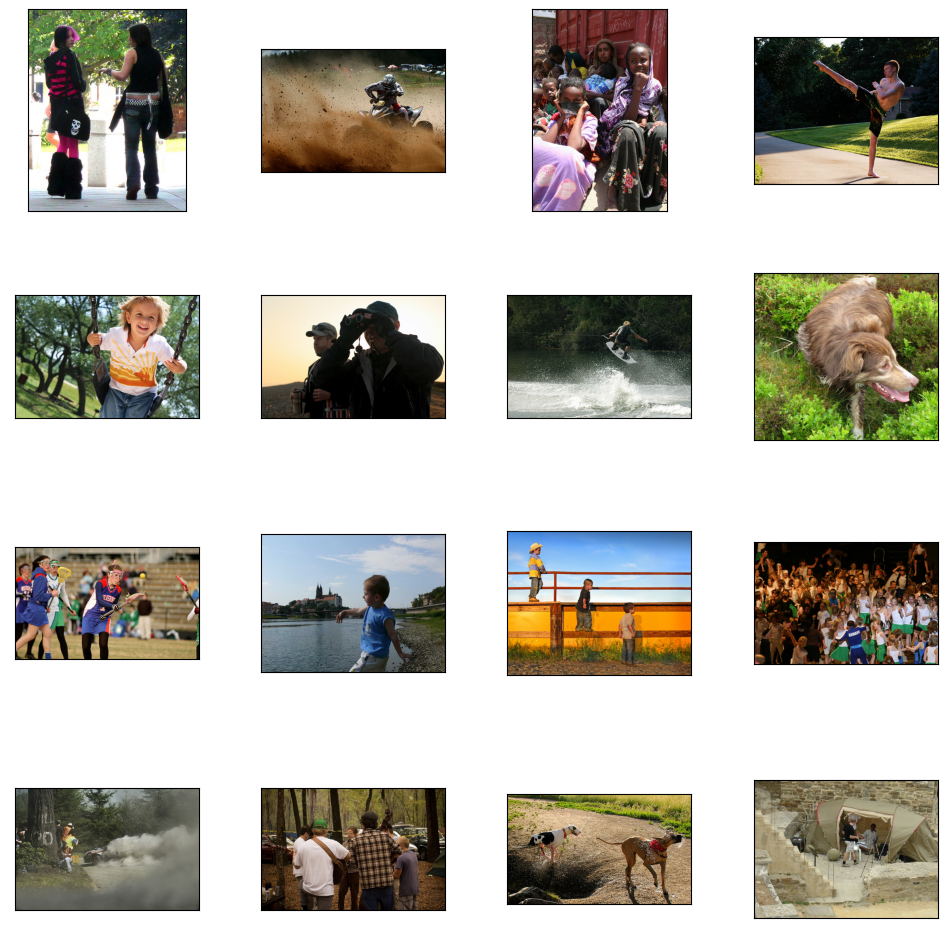

In [43]:
def read_df(path: str) -> tuple:
    '''Читаем датафреймы из указанной директории'''
    
    # Проверка наличия файлов перед чтением
    path = Path(path)
    train_path = path / 'train_dataset.csv'
    crowd_path = path / 'CrowdAnnotations.tsv'
    expert_path = path / 'ExpertAnnotations.tsv'
    queries_path = path / 'test_queries.csv'
    images_path = path / 'test_images.csv'
    
    if not train_path.exists():
        raise FileNotFoundError(f"Файл {train_path} не найден.")
    if not crowd_path.exists():
        raise FileNotFoundError(f"Файл {crowd_path} не найден.")
    if not expert_path.exists():
        raise FileNotFoundError(f"Файл {expert_path} не найден.")
    if not queries_path.exists():
        raise FileNotFoundError(f"Файл {queries_path} не найден.")
    if not images_path.exists():
        raise FileNotFoundError(f"Файл {images_path} не найден.")
    
    # Чтение данных
    df_train = pd.read_csv(train_path)
    df_crowd = pd.read_csv(crowd_path, sep='\t', names=['image', 'query_id', 'share_pos', 'count_pos', 'count_neg'])
    df_expert = pd.read_csv(expert_path, sep='\t', names=['image', 'query_id', 'first', 'second', 'third'])
    df_queries = pd.read_csv(queries_path, index_col=[0], sep='|')
    df_images = pd.read_csv(images_path, sep='|')
    
    return df_train, df_crowd, df_expert, df_queries, df_images

def display_images(path: str, df_train: pd.DataFrame, df_queries: pd.DataFrame):
    '''Отображение изображений из тренировочного и тестового наборов данных'''
    
    samples_train = list(df_train['image'].sample(8))
    samples_test = list(df_queries['image'].sample(8))
    
    fig, axes = plt.subplots(4, 4, figsize=(10, 10))
    fig.tight_layout()
    
    for i in range(8):
        train_image_path = Path(path) / 'train_images' / samples_train[i]
        test_image_path = Path(path) / 'test_images' / samples_test[i]
        
        # Отображение тренировочных изображений
        ax = axes[i // 4, i % 4]
        try:
            image = Image.open(train_image_path)
            ax.imshow(image)
            ax.set_xticks([])
            ax.set_yticks([])
        except FileNotFoundError:
            ax.text(0.5, 0.5, 'Image not found', horizontalalignment='center', verticalalignment='center')
            ax.set_xticks([])
            ax.set_yticks([])
        
        # Отображение тестовых изображений
        ax = axes[(i // 4) + 2, i % 4]
        try:
            image = Image.open(test_image_path)
            ax.imshow(image)
            ax.set_xticks([])
            ax.set_yticks([])
        except FileNotFoundError:
            ax.text(0.5, 0.5, 'Image not found', horizontalalignment='center', verticalalignment='center')
            ax.set_xticks([])
            ax.set_yticks([])

# Пример использования функции
path_to_data = 'C:\\datasets\\image_search\\to_upload'
df_train, df_crowd, df_expert, df_queries, df_images = read_df(path_to_data)
display_images(path_to_data, df_train, df_queries)
plt.show()

In [ ]:
# Функция для получения списка всех изображений в папке
def get_image_paths_from_folder(folder_path):
    image_paths = []
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
                image_paths.append(os.path.join(root, file))
    return image_paths

# Пример функции get_best_image (замените на вашу реализацию)
def get_best_image(text_description, model, vectorizer, image_df):
    # Ваша логика для выбора лучшего изображения
    # Здесь просто возвращается первый путь как пример
    return image_df['image_path'].iloc[0]

# Пример использования функции get_best_image
text_description_example = "dog"  # Замените на ваше текстовое описание
model = model  # Замените на вашу модель
vectorizer = text_vectors  # Замените на ваш векторизатор

# Путь к папке с изображениями (замените на ваш путь)
folder_path = 'C:\\datasets\\image_search\\to_upload\\test_images'

# Получаем все пути к изображениям в папке
image_paths = get_image_paths_from_folder(folder_path)

# Создаем DataFrame с путями к изображениям
image_df = pd.DataFrame({'image_path': image_paths})

# Получаем лучшее изображение
best_image_example = get_best_image(text_description_example, model, vectorizer, image_df)

print("Лучшее изображение для данного текста:")
if os.path.exists(best_image_example):
    try:
        img = Image.open(best_image_example)
        img.show()  # Отображение изображения с использованием PIL
    except Exception as e:
        print(f"Произошла ошибка при открытии изображения: {e}")
else:
    print(f"Изображение по пути {best_image_example} не найдено.")

Лучшее изображение для данного текста:
